In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import librosa.display
import numpy as np
import os
import IPython.display as ipd

In [2]:
device = None
dtype = torch.float32
if torch.cuda.is_available():
  device = torch.device('cuda')
else: device = torch.device('cpu')

In [3]:
!git clone https://github.com/soerenab/AudioMNIST.git

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30119, done.
remote: Total 30119 (delta 0), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30119/30119), 944.54 MiB | 27.63 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (30018/30018), done.


In [4]:
data, sr = librosa.load('AudioMNIST/data/01/0_01_0.wav',mono=True, sr=None)

In [5]:
data.shape

(35877,)

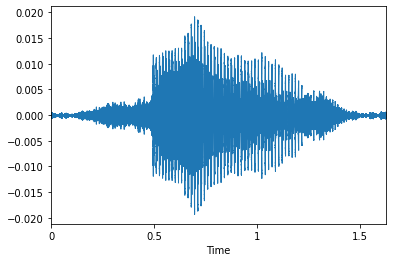

In [6]:
librosa.display.waveplot(data)

In [7]:
X = librosa.stft(data)

Xdb = librosa.amplitude_to_db(abs(librosa.stft(data)))

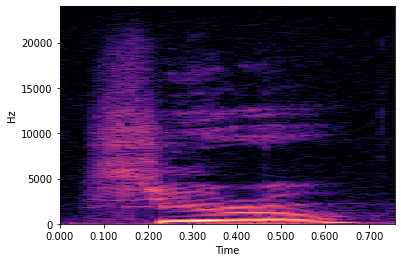

In [8]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [9]:
!pip install torchaudio
import torchaudio
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.9 MB 7.0 MB/s 


torch.Size([1, 35877]) <built-in method type of Tensor object at 0x7f086e194730>
48000


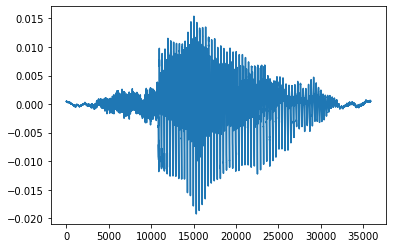

In [10]:
file = 'AudioMNIST/data/01/0_01_0.wav'
audio, sr = torchaudio.load(file)
print(audio.size(), audio.type) 
print(sr)
plt.plot(audio.t().numpy())

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torch/functional.py:472: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:664.)
  normalized, onesided, return_complex)


The slowest run took 26.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 783 µs per loop
torch.Size([1, 128, 180])


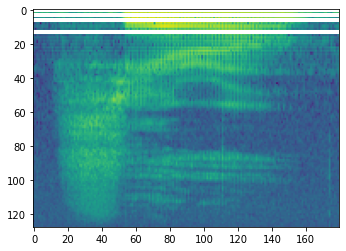

In [11]:
specgram = torchaudio.transforms.MelSpectrogram()(audio)
%timeit torchaudio.transforms.AmplitudeToDB(abs(torch.stft(audio, 4))) #clearly way faster than librosa
print(specgram.size())

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy())

In [12]:
audio = []
dir = 'AudioMNIST/data/'
#dir = 'free-spoken-digit-dataset/recordings'

for (root,dirs,files) in os.walk(dir):
  for file in files:
    if file.endswith('.wav'):
      path = root+'/'+file
      audio.append(path) #appends [data, sampling rate to audio]
      print(path)
    
      

Streaming output truncated to the last 5000 lines.
AudioMNIST/data/20/3_20_16.wav
AudioMNIST/data/20/7_20_29.wav
AudioMNIST/data/20/4_20_30.wav
AudioMNIST/data/20/2_20_24.wav
AudioMNIST/data/20/5_20_20.wav
AudioMNIST/data/20/7_20_18.wav
AudioMNIST/data/20/3_20_1.wav
AudioMNIST/data/20/6_20_1.wav
AudioMNIST/data/20/6_20_18.wav
AudioMNIST/data/20/6_20_49.wav
AudioMNIST/data/20/2_20_48.wav
AudioMNIST/data/20/4_20_8.wav
AudioMNIST/data/20/0_20_19.wav
AudioMNIST/data/20/6_20_17.wav
AudioMNIST/data/20/8_20_24.wav
AudioMNIST/data/20/7_20_0.wav
AudioMNIST/data/20/7_20_13.wav
AudioMNIST/data/20/7_20_34.wav
AudioMNIST/data/20/4_20_18.wav
AudioMNIST/data/20/6_20_20.wav
AudioMNIST/data/20/6_20_8.wav
AudioMNIST/data/20/1_20_33.wav
AudioMNIST/data/20/0_20_14.wav
AudioMNIST/data/20/5_20_33.wav
AudioMNIST/data/20/9_20_44.wav
AudioMNIST/data/20/3_20_34.wav
AudioMNIST/data/20/7_20_46.wav
AudioMNIST/data/20/4_20_11.wav
AudioMNIST/data/20/8_20_37.wav
AudioMNIST/data/20/5_20_2.wav
AudioMNIST/data/20/2_20_5

In [27]:
from tensorflow import keras

In [28]:
#audio
#keras.utils.to_categorical

<function tensorflow.python.keras.utils.np_utils.to_categorical>

In [29]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import sys

class DataGenerator:
  def __init__(self, dataset, max_len = 40):
    if dataset == "AudioMNIST":
      path = 'AudioMNIST/data/'
    elif dataset == 'freespeak': path = 'free-spoken-digit-dataset/recordings'
    self.path = path
    self.dataset = dataset;
    self.max_len = max_len
    print(path)

  def process_audio(self, file, root = None):
    '''
    returns audio's mfccs: 
    '''
    max_len = self.max_len;
    if root is None:
      path = os.path.join(self.path, file)
    else:
      path = os.path.join(root, file)
    wave, sr = librosa.load(path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=8000)
    #chroma_stft = librosa.feature.chroma_stft(wave, sr=8000)
    
    pad_width = max_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    #pad_width_chroma_stft = max_len - chroma_stft.shape[1]
    #chroma_stft = np.pad(chroma_stft, pad_width=((0, 8), (0, pad_width_chroma_stft)), mode='constant')
    return mfcc
    #wave, sr = torchaudio.load_wav(path)
    # shifting to pytorch
    # mel = torchaudio.transform.MelSpectrogram(wave, )
    # pad_width = max_len - mel.shape[1]
    # mel_padded = 

    # return mel_padded

  def __get_data(self):
    '''returns audio files after extracting mfc features and categorical labels'''
    label = []
    data = []
    dir = self.path
    i=0
    
    for (root,dirs,files) in os.walk(dir):
      for file in files:
        i+=1
        if file.endswith('.wav'):
          data.append(self.process_audio(file, root = root))
          
          label.append(file.split('_')[0][0])
          sys.stdout.write("\rDoing thing %i" % i)
          sys.stdout.flush()
    return np.asarray(data), keras.utils.to_categorical(label)

  def get_data(self, test_size = 0.1, val_size = 0.1):
    data, labels = self.__get_data()
    X, X_test, y, y_test = train_test_split(data, labels, test_size=test_size, random_state = 1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state = 2)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [31]:
dataset = DataGenerator('AudioMNIST') 

X_train, X_val, X_test, y_train, y_val, y_test = dataset.get_data(test_size = 0.2, val_size = 0.111)

AudioMNIST/data/
Doing thing 30001

In [32]:
import pickle

In [34]:
X_train.shape

(21336, 20, 40)

In [35]:

data = {
    'X_train': X_train, 'y_train': y_train,
    'X_test': X_test, 'y_test':y_test,
    'X_val': X_val, 'y_val': y_val
}
for key in data.keys():
  mat = data[key]
  pickle.dump( mat, open( "Data/"+key+".pkl", "wb" ) )

In [ ]:
#new_data = pickle.load(open('Data/X_train.pkl', 'rb'))
#new_data = np.reshape(new_data, (2000, 20, 20))
#assert (new_data == X_train).all()

In [38]:
!zip -r file.zip Data
from google.colab import files
files.download("file.zip")

  adding: Data/ (stored 0%)
  adding: Data/X_val.pkl (deflated 50%)
  adding: Data/y_train.pkl (deflated 97%)
  adding: Data/X_train.pkl (deflated 50%)
  adding: Data/y_test.pkl (deflated 97%)
  adding: Data/X_test.pkl (deflated 50%)
  adding: Data/y_val.pkl (deflated 97%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
#For loading data from colab
'''
import pickle
data={}
keys = 'X_train, X_val, X_test, y_train, y_val, y_test'.split(', ')
for key in keys:
  path = '/content/drive/My Drive/Stride/audio/Data/' #"Data/"
  mat = pickle.load( open( path +key+".pkl", "rb" ) )
  data.update({key : mat} )

X_train, X_val, X_test, y_train, y_val, y_test = [y for y in data.values()]
'''

'\nimport pickle\ndata={}\nkeys = \'X_train, X_val, X_test, y_train, y_val, y_test\'.split(\', \')\nfor key in keys:\n  path = \'/content/drive/My Drive/Stride/audio/Data/\' #"Data/"\n  mat = pickle.load( open( path +key+".pkl", "rb" ) )\n  data.update({key : mat} )\n\nX_train, X_val, X_test, y_train, y_val, y_test = [y for y in data.values()]\n'

In [40]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU

#from ann_visualizer.visualize import ann_viz

def get_cnn_model(input_shape, num_classes, d = 0.2):
  model = Sequential()
  #model.add(Input(shape= (20,20,1) ))
  #conv
  model.add(Conv2D(32, kernel_size=3,  input_shape = input_shape)) #18
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #conv
  model.add(Conv2D(64, kernel_size=3)) #16
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #pool
  model.add(Conv2D(32, kernel_size=2, strides = 2)) #8
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  #model.add(Dropout(d))
  #conv
  model.add(Conv2D(64, kernel_size=5, padding = 'same')) #8
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #conv
  model.add(Conv2D(128, kernel_size=3, padding = 'same')) #8
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #pool
  model.add(Conv2D(128, kernel_size=2, strides = 2, activation='relu')) #2
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  #model.add(Dropout(d))

  model.add(Flatten())
  #2 x FC
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(100))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(num_classes, activation='softmax'))

  #model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
  
  return model


In [41]:
#model params and minor reshaping
dim = X_train.shape[1]
assert dim == 20
channels =1
X_train = X_train.reshape((X_train.shape[0], dim, 40, channels))
X_val = X_val.reshape((X_val.shape[0], dim, 40, channels))
X_test = X_test.reshape((X_test.shape[0], dim, 40, channels))
input_shape = (dim, 40, 1)
classes = 10

In [42]:
X_train.shape

(21336, 20, 40, 1)

In [43]:
from keras.optimizers import Adam

In [44]:
model = get_cnn_model(input_shape, classes) #, 0.4
opt = keras.optimizers.Adam(learning_rate=1e-3)#, decay = 0.95)
# model.compile(optimizer=opt,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=50, 
                    validation_data=(X_val, y_val), verbose = 1)

Epoch 1/50
334/334 [==============================] - 53s 16ms/step - loss: 0.6931 - accuracy: 0.7821 - val_loss: 0.0305 - val_accuracy: 0.9914
Epoch 2/50
334/334 [==============================] - 4s 12ms/step - loss: 0.0585 - accuracy: 0.9844 - val_loss: 0.0154 - val_accuracy: 0.9947
Epoch 3/50
334/334 [==============================] - 4s 12ms/step - loss: 0.0341 - accuracy: 0.9907 - val_loss: 0.0090 - val_accuracy: 0.9977
Epoch 4/50
334/334 [==============================] - 4s 12ms/step - loss: 0.0203 - accuracy: 0.9946 - val_loss: 0.0816 - val_accuracy: 0.9718
Epoch 5/50
334/334 [==============================] - 4s 12ms/step - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.0077 - val_accuracy: 0.9977
Epoch 6/50
334/334 [==============================] - 4s 12ms/step - loss: 0.0149 - accuracy: 0.9961 - val_loss: 0.0110 - val_accuracy: 0.9974
Epoch 7/50
334/334 [==============================] - 4s 12ms/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.0091 - val_accuracy: 0.997

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 38, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 38, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 18, 38, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 38, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 36, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 36, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 36, 64)        0

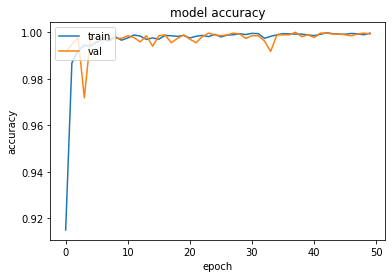

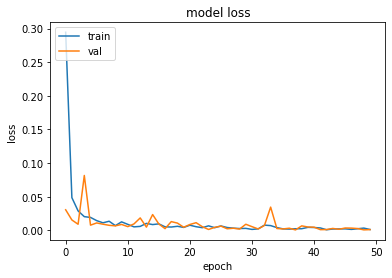

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
model.evaluate(X_test, y_test, batch_size=64)

94/94 [==============================] - 1s 6ms/step - loss: 9.1142e-04 - accuracy: 0.9995


[0.0009114163694903255, 0.9994999766349792]

In [48]:
model.save_weights('model_weights.h5')